In [51]:
import matplotlib.pyplot as plt
import numpy as np

input_dir = './data/'
filename = 'CARAS71 .ELH'
fs = 500 # частота дискретизации, Гц
stim_start_time = 10 # начало фоновой засветки, с
stim_duration = 10 # длительность фоновой засветки, с
first_impulse_start_time = 1 # начало первого импульса, с
period = 15 # период следования импульсов, с
after_stim_start_time = first_impulse_start_time + ((stim_start_time + stim_duration) // period  + 1) * period


with open(input_dir + filename, 'r', encoding='utf-8') as file:
    line = file.readline()
    while line and line[0] not in '-.':
        line = file.readline()
    signal = [float('0' if line == '.\n' else line)]
    for line in file:
        signal.append(float('0' if line == '.\n' else line))
    signal = np.array(signal)

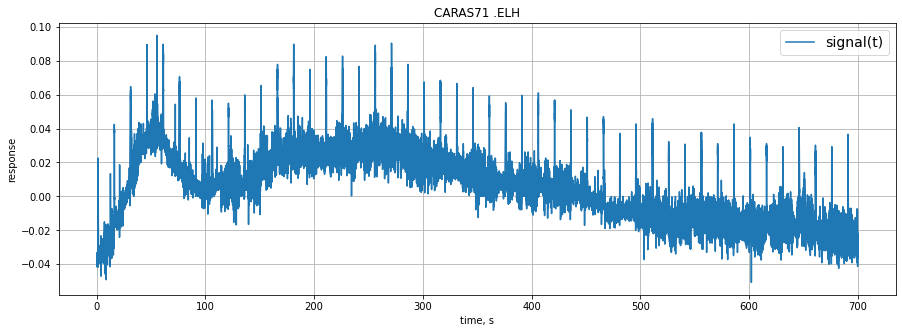

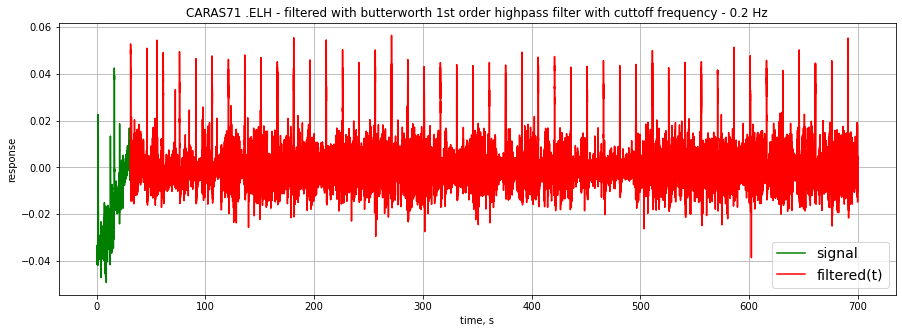

In [52]:
from scipy.signal import butter, lfilter

nyq = 0.5 * fs
low_cutoff = 0.2
b, a = butter(1, low_cutoff / nyq, btype='highpass', analog=False)
filtered = lfilter(b, a, signal)

n = signal.size
t = np.linspace(0, (n - 1) / fs, n)
fig, ax = plt.subplots()
ax.plot(t, signal, label='signal(t)')
fig.set_figwidth(15)
fig.set_figheight(5)
ax.set_xlabel('time, s')
ax.set_ylabel('response')
ax.set_title(filename)
ax.legend(prop={"size": 14})
ax.grid()

fig, ax = plt.subplots()
ax.plot(t[0:after_stim_start_time * fs], signal[0:after_stim_start_time * fs], 'g', label='signal')
ax.plot(t[after_stim_start_time * fs:], filtered[after_stim_start_time * fs:], 'r', label='filtered(t)')
fig.set_figwidth(15)
fig.set_figheight(5)
ax.set_xlabel('time, s')
ax.set_ylabel('response')
ax.set_title(f'{filename} - filtered with butterworth 1st order highpass filter with cuttoff frequency - {low_cutoff} Hz')
ax.legend(prop={"size": 14})
ax.grid()

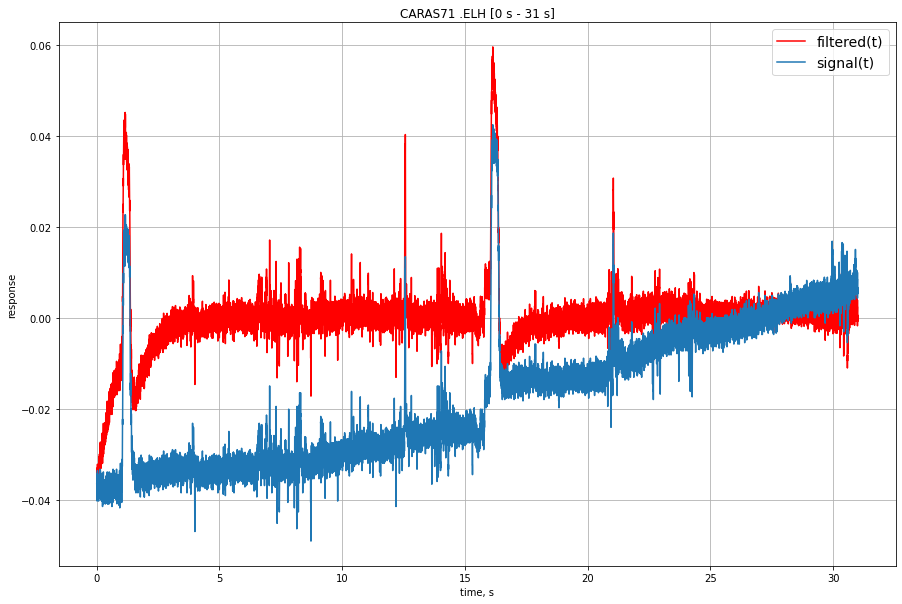

In [53]:
fig, ax = plt.subplots()
start_time = 0
end_time = after_stim_start_time
ax.plot(t[start_time * fs:end_time * fs + 1], filtered[start_time * fs:end_time * fs + 1], 'r', label='filtered(t)')
ax.plot(t[start_time * fs:end_time * fs + 1], signal[start_time * fs:end_time * fs + 1], label='signal(t)')
fig.set_figwidth(15)
fig.set_figheight(10)
ax.set_xlabel('time, s')
ax.set_ylabel('response')
ax.set_title(f'{filename} [{start_time} s - {end_time} s]')
ax.legend(prop={"size": 14})
ax.grid()

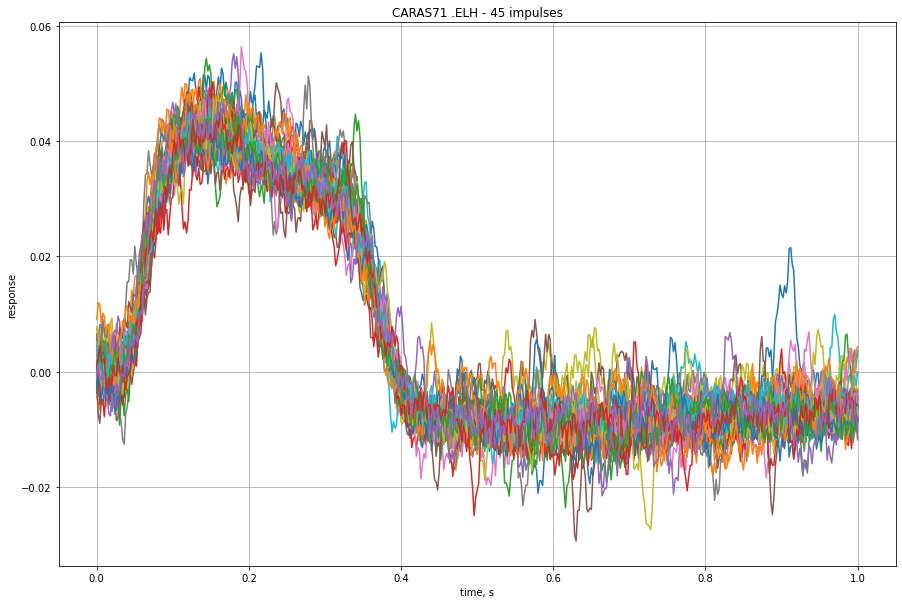

In [54]:
impulses_cnt = ((n - 1) // fs - after_stim_start_time) // period + 1
impulses = []
for i in range(impulses_cnt):
    start_time = (after_stim_start_time + period * i) * fs
    end_time = start_time + fs
    impulses.append(filtered[start_time:end_time + 1])
temp_t = np.linspace(0, 1, fs + 1)
fig, ax = plt.subplots()
for impulse in impulses:
    ax.plot(temp_t, impulse)
fig.set_figwidth(15)
fig.set_figheight(10)
ax.set_xlabel('time, s')
ax.set_ylabel('response')
ax.set_title(f'{filename} - {impulses_cnt} impulses')
ax.grid()

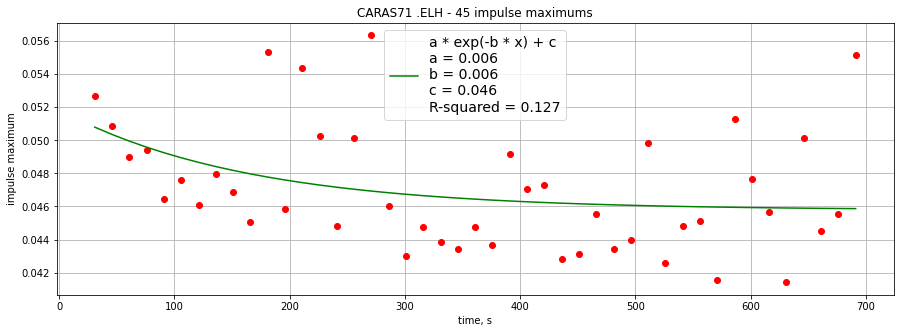

In [55]:
from scipy import stats, optimize

def func(x, a, b, c):
    return a * np.exp(-b * x) + c

maximums = np.array([max(impulse) for impulse in impulses])
temp_x = np.linspace(after_stim_start_time, after_stim_start_time + (impulses_cnt - 1) * period, impulses_cnt)
popt, pcov = optimize.curve_fit(func, temp_x, maximums, [-0.05, 0.01, 0.05])
fit = func(temp_x, *popt)
rvalue = stats.linregress(maximums, fit).rvalue

fig, ax = plt.subplots()
ax.plot(temp_x, maximums, 'ro')
ax.plot(temp_x, fit, 'g', label=f'a * exp(-b * x) + c\n'
                           f'a = {popt[0]:.3f}\n'
                           f'b = {popt[1]:.3f}\n'
                           f'c = {popt[2]:.3f}\n'
                           f'R-squared = {rvalue ** 2:.3f}')
fig.set_figwidth(15)
fig.set_figheight(5)
ax.set_xlabel('time, s')
ax.set_ylabel('impulse maximum')
ax.set_title(f'{filename} - {impulses_cnt} impulse maximums')
ax.legend(prop={"size": 14})
ax.grid()